# IT2-Phase 1 : Entraînement rapide (1000 exemples) pour validation du pipeline



In [ ]:

from google.colab import drive
import os

drive.mount('/content/drive')
PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'
os.makedirs(PROJECT_DIR, exist_ok=True)

print(f"📁 Projet : {PROJECT_DIR}")

Mounted at /content/drive
📁 Projet : /content/drive/MyDrive/RCP217_Projet_Summarization


In [ ]:
# Installation des dépendances
!pip install transformers torch rouge-score sentencepiece -q

# Vérification des versions
import torch
import transformers
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

  Preparing metadata (setup.py) ... done
PyTorch version: 2.9.0+cu126
Transformers version: 4.57.6
CUDA available: True


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW # Corrected import
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
import warnings
warnings.filterwarnings('ignore')

##Config Phase 1

In [ ]:


# ==========================================
# PARTIE 1 : CONFIGURATION & SETUP
# ==========================================

class Config:
    """Configuration centralisée du projet"""

    # Chemins
    PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'

    # Modèle
    MODEL_NAME = 't5-small'  # 60M paramètres, fonctionne sur Colab gratuit
    MAX_INPUT_LENGTH = 512   # (ou 256 si pb de memeoire) Longueur max article (tokens)
    MAX_TARGET_LENGTH = 128  # Longueur max résumé (tokens)

    # Entraînement
    BATCH_SIZE = 4           # Ajuster (ou 2) selon mémoire GPU disponible
    LEARNING_RATE = 3e-4     # Learning rate initial
    NUM_EPOCHS = 3           # Nombre d'époques
    WARMUP_STEPS = 500       # Steps de warmup

    # Évaluation
    EVAL_BATCH_SIZE = 8
    NUM_BEAMS = 4            # Beam search pour génération

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @staticmethod
    def print_config():
        """Affiche la configuration"""
        print("⚙️  CONFIGURATION")
        print("="*60)
        print(f"Modèle         : {Config.MODEL_NAME}")
        print(f"Device         : {Config.DEVICE}")
        print(f"Batch size     : {Config.BATCH_SIZE}")
        print(f"Learning rate  : {Config.LEARNING_RATE}")
        print(f"Époques        : {Config.NUM_EPOCHS}")
        print(f"Max input      : {Config.MAX_INPUT_LENGTH} tokens")
        print(f"Max target     : {Config.MAX_TARGET_LENGTH} tokens")
        print("="*60)


def check_gpu():
    """Vérifie la disponibilité du GPU"""
    print("\n🔍 VÉRIFICATION GPU")
    print("="*60)

    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"✅ GPU disponible : {gpu_name}")
        print(f"   Mémoire totale : {gpu_memory:.1f} GB")

        # Vérifier mémoire libre
        torch.cuda.empty_cache()
        free_memory = torch.cuda.memory_reserved(0) / 1e9
        print(f"   Mémoire libre  : {free_memory:.1f} GB")
    else:
        print("⚠️  Pas de GPU détecté - L'entraînement sera TRÈS lent sur CPU")
        print("   Recommandation : Activer GPU dans Runtime > Change runtime type")

    print("="*60)


# ==========================================
# PARTIE 2 : DATASET PYTORCH
# ==========================================

class CNNDailyMailDataset(Dataset):
    """
    Dataset PyTorch pour CNN/Daily Mail avec T5
    T5 utilise le format : "summarize: <article>" → "<summary>"
    """

    def __init__(self, dataframe, tokenizer, max_input_length=512, max_target_length=128):
        """
        Args:
            dataframe: DataFrame avec colonnes 'article' et 'highlights'
            tokenizer: T5Tokenizer
            max_input_length: longueur max de l'input
            max_target_length: longueur max du target
        """
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Récupère un exemple du dataset"""
        row = self.data.iloc[idx]

        # Article avec préfixe T5
        article = row['article']
        source_text = f"summarize: {article}"

        # Résumé de référence (joindre les highlights)
        if isinstance(row['highlights'], list):
            target_text = ' '.join(row['highlights'])
        else:
            target_text = row['highlights']

        # Tokenization de l'input
        source_encoding = self.tokenizer(
            source_text,
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenization du target
        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Préparer les labels (remplacer padding par -100 pour ignorer dans loss)
        labels = target_encoding['input_ids'].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': source_encoding['input_ids'].squeeze(),
            'attention_mask': source_encoding['attention_mask'].squeeze(),
            'labels': labels
        }


def prepare_dataloaders(train_df, val_df, tokenizer, config):
    """Prépare les DataLoaders pour l'entraînement"""

    print("\n📦 PRÉPARATION DES DATALOADERS")
    print("="*60)

    # Créer les datasets
    train_dataset = CNNDailyMailDataset(
        train_df,
        tokenizer,
        max_input_length=config.MAX_INPUT_LENGTH,
        max_target_length=config.MAX_TARGET_LENGTH
    )

    val_dataset = CNNDailyMailDataset(
        val_df,
        tokenizer,
        max_input_length=config.MAX_INPUT_LENGTH,
        max_target_length=config.MAX_TARGET_LENGTH
    )

    print(f"✅ Train dataset : {len(train_dataset)} exemples")
    print(f"✅ Val dataset   : {len(val_dataset)} exemples")

    # Créer les dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.EVAL_BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"✅ Train batches : {len(train_loader)}")
    print(f"✅ Val batches   : {len(val_loader)}")
    print("="*60)

    return train_loader, val_loader


# ==========================================
# PARTIE 3 : ENTRAÎNEMENT
# ==========================================

class T5Trainer:
    """Classe pour gérer l'entraînement de T5"""

    def __init__(self, model, tokenizer, config):
        self.model = model
        self.tokenizer = tokenizer
        self.config = config
        self.device = config.DEVICE

        # Historique
        self.train_losses = []
        self.val_losses = []

    def train_epoch(self, train_loader, optimizer, scheduler, epoch):
        """Entraîne le modèle pour une époque"""
        self.model.train()
        total_loss = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{self.config.NUM_EPOCHS}")

        for batch in progress_bar:
            # Déplacer sur GPU
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            # Forward pass
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            # Mise à jour progress bar
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(train_loader)
        self.train_losses.append(avg_loss)

        return avg_loss

    def validate(self, val_loader):
        """Évalue le modèle sur l'ensemble de validation"""
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_loss += outputs.loss.item()

        avg_loss = total_loss / len(val_loader)
        self.val_losses.append(avg_loss)

        return avg_loss

    def plot_losses(self):
        """Visualise les courbes de loss"""
        plt.figure(figsize=(10, 6))
        epochs = range(1, len(self.train_losses) + 1)

        plt.plot(epochs, self.train_losses, 'b-o', label='Train Loss')
        plt.plot(epochs, self.val_losses, 'r-o', label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('t5_training_losses.png', dpi=300)
        plt.show()

        print("📊 Graphique sauvegardé : t5_training_losses.png")


# ==========================================
# PARTIE 4 : GÉNÉRATION DE RÉSUMÉS
# ==========================================

def generate_summaries_t5(model, tokenizer, dataframe, config, max_samples=None):
    """
    Génère des résumés avec le modèle T5 fine-tuné

    Args:
        model: modèle T5 fine-tuné
        tokenizer: tokenizer T5
        dataframe: DataFrame avec colonne 'article'
        config: configuration
        max_samples: nombre max d'exemples (None = tous)

    Returns:
        Liste de résumés générés
    """
    model.eval()
    summaries = []

    df_sample = dataframe.head(max_samples) if max_samples else dataframe

    for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Génération résumés"):
        article = row['article']
        source_text = f"summarize: {article}"

        # Tokenization
        inputs = tokenizer(
            source_text,
            max_length=config.MAX_INPUT_LENGTH,
            truncation=True,
            return_tensors='pt'
        ).to(config.DEVICE)

        # Génération avec beam search
        with torch.no_grad():
            summary_ids = model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=config.MAX_TARGET_LENGTH,
                num_beams=config.NUM_BEAMS,
                early_stopping=True,
                no_repeat_ngram_size=3  # Éviter répétitions
            )

        # Décodage
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)

    return summaries

##Main script Phase 1

🚀 ITÉRATION 2 : RÉSUMÉ ABSTRACTIF AVEC T5-SMALL

🔍 VÉRIFICATION GPU
✅ GPU disponible : Tesla T4
   Mémoire totale : 15.8 GB
   Mémoire libre  : 0.0 GB
⚙️  CONFIGURATION
Modèle         : t5-small
Device         : cuda
Batch size     : 4
Learning rate  : 0.0003
Époques        : 3
Max input      : 512 tokens
Max target     : 128 tokens

📂 CHARGEMENT DES DONNÉES
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Train : 12000 exemples
✅ Val   : 1500 exemples
✅ Test  : 1500 exemples

📝 PHASE 1 : ENTRAÎNEMENT RAPIDE (1000 exemples)

🔧 Chargement du modèle T5-small...


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ Modèle chargé : t5-small
   Nombre de paramètres : 60.5M

📦 PRÉPARATION DES DATALOADERS
✅ Train dataset : 1000 exemples
✅ Val dataset   : 200 exemples
✅ Train batches : 250
✅ Val batches   : 25

🏋️ DÉBUT DE L'ENTRAÎNEMENT


Validation: 100%|██████████| 25/25 [00:02<00:00,  8.48it/s]



Epoch 1/3
  Train Loss : 3.0039
  Val Loss   : 2.3593


Validation: 100%|██████████| 25/25 [00:03<00:00,  8.23it/s]



Epoch 2/3
  Train Loss : 2.5321
  Val Loss   : 2.3248


Validation: 100%|██████████| 25/25 [00:03<00:00,  8.19it/s]



Epoch 3/3
  Train Loss : 2.3034
  Val Loss   : 2.3014


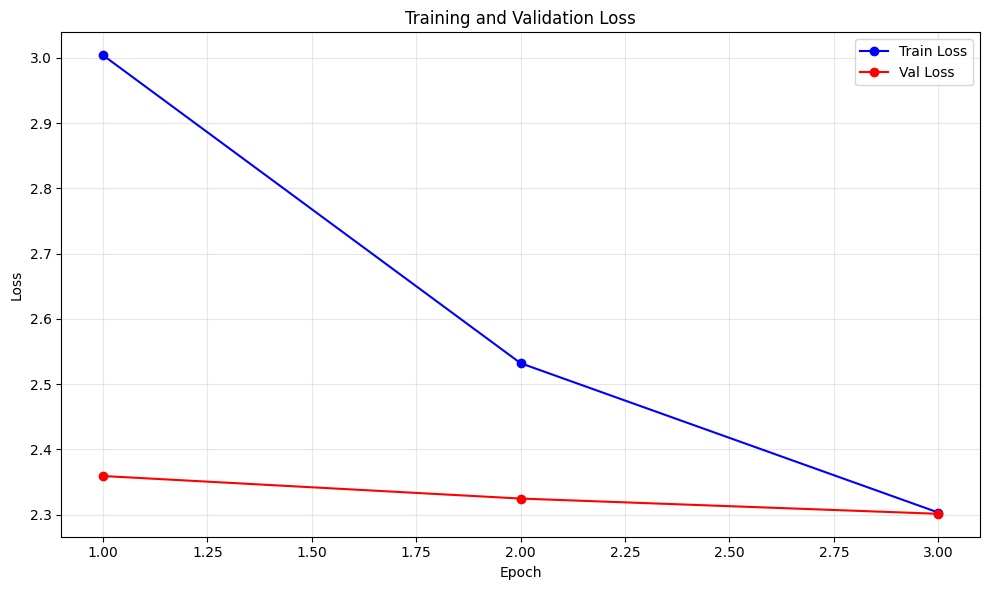

📊 Graphique sauvegardé : t5_training_losses.png

💾 SAUVEGARDE DU MODÈLE
✅ Modèle sauvegardé dans : /content/drive/MyDrive/RCP217_Projet_Summarization/models/t5_small_phase1

✨ PHASE 1 TERMINÉE !

📌 Prochaines étapes :
  1. Générer quelques résumés pour validation qualitative
  2. Évaluer avec ROUGE sur val set
  3. Si satisfaisant, lancer Phase 2 (entraînement complet)


In [ ]:
# ==========================================
# PARTIE 5 : SCRIPT PRINCIPAL
# ==========================================

if __name__ == "__main__":

    print("🚀 ITÉRATION 2 : RÉSUMÉ ABSTRACTIF AVEC T5-SMALL")
    print("="*60)

    # Vérifier GPU
    check_gpu()

    # Configuration
    config = Config()
    config.print_config()

    # Charger les données
    print("\n📂 CHARGEMENT DES DONNÉES")
    print("="*60)

    from google.colab import drive
    drive.mount('/content/drive')

    train_df = pd.read_pickle(f'{config.PROJECT_DIR}/train_data.pkl')
    val_df = pd.read_pickle(f'{config.PROJECT_DIR}/val_data.pkl')
    test_df = pd.read_pickle(f'{config.PROJECT_DIR}/test_data.pkl')

    print(f"✅ Train : {len(train_df)} exemples")
    print(f"✅ Val   : {len(val_df)} exemples")
    print(f"✅ Test  : {len(test_df)} exemples")

    # PHASE 1 : ENTRAÎNEMENT RAPIDE (1000 exemples)
    # Pour validation du pipeline
    print("\n" + "="*60)
    print("📝 PHASE 1 : ENTRAÎNEMENT RAPIDE (1000 exemples)")
    print("="*60)

    train_sample = train_df.head(1000)
    val_sample = val_df.head(200)

    # Initialiser tokenizer et modèle
    print("\n🔧 Chargement du modèle T5-small...")
    tokenizer = T5Tokenizer.from_pretrained(config.MODEL_NAME)
    model = T5ForConditionalGeneration.from_pretrained(config.MODEL_NAME)
    model.to(config.DEVICE)

    print(f"✅ Modèle chargé : {config.MODEL_NAME}")
    print(f"   Nombre de paramètres : {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

    # Préparer dataloaders
    train_loader, val_loader = prepare_dataloaders(train_sample, val_sample, tokenizer, config)

    # Optimizer et scheduler
    optimizer = AdamW(model.parameters(), lr=config.LEARNING_RATE)
    total_steps = len(train_loader) * config.NUM_EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=config.WARMUP_STEPS,
        num_training_steps=total_steps
    )

    # Entraîner
    trainer = T5Trainer(model, tokenizer, config)

    print("\n🏋️ DÉBUT DE L'ENTRAÎNEMENT")
    print("="*60)

    for epoch in range(config.NUM_EPOCHS):
        train_loss = trainer.train_epoch(train_loader, optimizer, scheduler, epoch)
        val_loss = trainer.validate(val_loader)

        print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
        print(f"  Train Loss : {train_loss:.4f}")
        print(f"  Val Loss   : {val_loss:.4f}")

    # Visualiser losses
    trainer.plot_losses()

    # Sauvegarder le modèle
    print("\n💾 SAUVEGARDE DU MODÈLE")
    model_path = f'{config.PROJECT_DIR}/models/t5_small_phase1'
    os.makedirs(model_path, exist_ok=True)
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)
    print(f"✅ Modèle sauvegardé dans : {model_path}")

    print("\n" + "="*60)
    print("✨ PHASE 1 TERMINÉE !")
    print("="*60)


#IT2-Phase 1bis : Évaluation du modèle T5 Phase 1

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
import warnings
warnings.filterwarnings('ignore')

## Préparation Phase 1bis

🚀 ÉVALUATION MODÈLE T5 - PHASE 1

📥 CHARGEMENT DU MODÈLE ENTRAÎNÉ
✅ Modèle chargé depuis : /content/drive/MyDrive/RCP217_Projet_Summarization/models/t5_small_phase1
   Device : cuda

📂 Chargement des données de validation...
✅ Évaluation sur 500 exemples

📝 Génération des résumés avec T5...


Évaluation ROUGE: 100%|██████████| 500/500 [00:00<00:00, 697.03it/s]



📊 SCORES ROUGE MOYENS - T5 ABSTRACTIF

ROUGE-1:
  F1-score:  0.3519
  Precision: 0.3812
  Recall:    0.3407

ROUGE-2:
  F1-score:  0.1443
  Precision: 0.1562
  Recall:    0.1403

ROUGE-L:
  F1-score:  0.2483
  Precision: 0.2688
  Recall:    0.2408

📊 COMPARAISON EXTRACTIF vs ABSTRACTIF (T5)

| Métrique  | Extractif | Abstractif T5 | Gain     |
|-----------|-----------|---------------|----------|
| ROUGE-1   | 0.2941    | 0.3519        | 📈 +19.7% |
| ROUGE-2   | 0.0927    | 0.1443        | 📈 +55.6% |
| ROUGE-L   | 0.1885    | 0.2483        | 📈 +31.7% |

📊 Graphique sauvegardé : comparison_extractive_abstractive.png


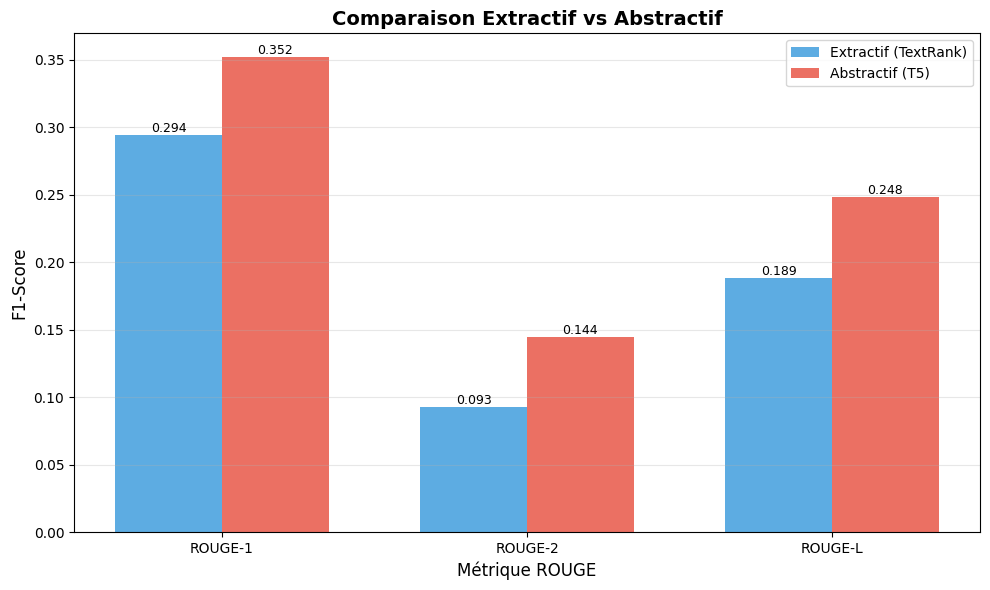


📝 EXEMPLES QUALITATIFS - RÉSUMÉS T5

────────────────────────────────────────────────────────────────────────────────
EXEMPLE 1
────────────────────────────────────────────────────────────────────────────────

📰 ARTICLE ORIGINAL (798 mots):
A strong U.S. military is indispensable to our national security . As retired military officers , we have dedicated our careers , on active duty and retired , to that end . We have been involved in crafting and teaching national security strategy , of which military strategy and use of military force are vital components . In the debate over the Pentagon budget and with threats of deeper cuts comi...

🤖 RÉSUMÉ T5 (37 mots):
a strong U.S. military is indispensable to our national security, he says He says the president, Congress, governors and defense community are rightly concerned about sequestration The crisis is driven by legions of lobbyists for parochial interests

✅ RÉSUMÉ RÉFÉRENCE (66 mots):
  1. Writers : Pentagon spending is based on stra

In [ ]:


"""
Projet RCP217 - Génération de résumés CNN/Daily Mail
Itération 2 - Phase 1bis : Évaluation du modèle T5 Phase 1

Objectif : Évaluer les performances du modèle entraîné sur 1000 exemples
"""



# ==========================================
# PARTIE 1 : CHARGEMENT DU MODÈLE ENTRAÎNÉ
# ==========================================

def load_trained_model(model_path, device):
    """Charge le modèle T5 fine-tuné"""
    print("\n📥 CHARGEMENT DU MODÈLE ENTRAÎNÉ")
    print("="*60)

    tokenizer = T5Tokenizer.from_pretrained(model_path)
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    model.to(device)
    model.eval()

    print(f"✅ Modèle chargé depuis : {model_path}")
    print(f"   Device : {device}")
    print("="*60)

    return model, tokenizer


# ==========================================
# PARTIE 2 : GÉNÉRATION DE RÉSUMÉS
# ==========================================

def generate_summaries_batch(model, tokenizer, articles, device,
                             max_input_length=512, max_output_length=128,
                             num_beams=4):
    """
    Génère des résumés pour une liste d'articles

    Args:
        model: modèle T5 fine-tuné
        tokenizer: tokenizer T5
        articles: liste d'articles
        device: cuda ou cpu
        max_input_length: longueur max input
        max_output_length: longueur max output
        num_beams: nombre de beams pour beam search

    Returns:
        Liste de résumés générés
    """
    summaries = []

    for article in tqdm(articles, desc="Génération résumés T5"):
        # Préfixe T5
        source_text = f"summarize: {article}"

        # Tokenization
        inputs = tokenizer(
            source_text,
            max_length=max_input_length,
            truncation=True,
            return_tensors='pt'
        ).to(device)

        # Génération
        with torch.no_grad():
            summary_ids = model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=max_output_length,
                min_length=30,              # Longueur minimale
                num_beams=num_beams,        # Beam search
                length_penalty=2.0,         # Favorise résumés plus longs
                early_stopping=True,
                no_repeat_ngram_size=3,     # Éviter répétitions
                repetition_penalty=2.5      # Pénaliser répétitions
            )

        # Décodage
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)

    return summaries


# ==========================================
# PARTIE 3 : ÉVALUATION ROUGE
# ==========================================

class ROUGEEvaluator:
    """Évaluateur ROUGE (réutilisation de l'itération 1)"""

    def __init__(self):
        self.scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'],
            use_stemmer=True
        )

    def compute_rouge(self, prediction, reference):
        """Calcule scores ROUGE entre prédiction et référence"""
        if isinstance(reference, list):
            reference = ' '.join(reference)

        scores = self.scorer.score(reference, prediction)
        return scores

    def evaluate_dataset(self, predictions, references):
        """Évalue un ensemble de prédictions"""
        all_scores = []

        for pred, ref in tqdm(zip(predictions, references),
                              total=len(predictions),
                              desc="Évaluation ROUGE"):
            if isinstance(ref, list):
                ref_text = ' '.join(ref)
            else:
                ref_text = ref

            scores = self.compute_rouge(pred, ref_text)

            all_scores.append({
                'rouge1_f': scores['rouge1'].fmeasure,
                'rouge1_p': scores['rouge1'].precision,
                'rouge1_r': scores['rouge1'].recall,
                'rouge2_f': scores['rouge2'].fmeasure,
                'rouge2_p': scores['rouge2'].precision,
                'rouge2_r': scores['rouge2'].recall,
                'rougeL_f': scores['rougeL'].fmeasure,
                'rougeL_p': scores['rougeL'].precision,
                'rougeL_r': scores['rougeL'].recall,
            })

        results_df = pd.DataFrame(all_scores)
        mean_scores = results_df.mean()

        print("\n" + "="*60)
        print("📊 SCORES ROUGE MOYENS - T5 ABSTRACTIF")
        print("="*60)
        print(f"\nROUGE-1:")
        print(f"  F1-score:  {mean_scores['rouge1_f']:.4f}")
        print(f"  Precision: {mean_scores['rouge1_p']:.4f}")
        print(f"  Recall:    {mean_scores['rouge1_r']:.4f}")

        print(f"\nROUGE-2:")
        print(f"  F1-score:  {mean_scores['rouge2_f']:.4f}")
        print(f"  Precision: {mean_scores['rouge2_p']:.4f}")
        print(f"  Recall:    {mean_scores['rouge2_r']:.4f}")

        print(f"\nROUGE-L:")
        print(f"  F1-score:  {mean_scores['rougeL_f']:.4f}")
        print(f"  Precision: {mean_scores['rougeL_p']:.4f}")
        print(f"  Recall:    {mean_scores['rougeL_r']:.4f}")

        return results_df, mean_scores


# ==========================================
# PARTIE 4 : COMPARAISON EXTRACTIF vs ABSTRACTIF
# ==========================================

def compare_with_baseline(t5_scores, extractive_baseline):
    """
    Compare les scores T5 avec la baseline extractive

    Args:
        t5_scores: scores ROUGE du T5
        extractive_baseline: dict avec scores extractifs
    """
    print("\n" + "="*60)
    print("📊 COMPARAISON EXTRACTIF vs ABSTRACTIF (T5)")
    print("="*60)

    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    extractive = [
        extractive_baseline['rouge1'],
        extractive_baseline['rouge2'],
        extractive_baseline['rougeL']
    ]
    abstractive = [
        t5_scores['rouge1_f'],
        t5_scores['rouge2_f'],
        t5_scores['rougeL_f']
    ]

    # Tableau comparatif
    print("\n| Métrique  | Extractif | Abstractif T5 | Gain     |")
    print("|-----------|-----------|---------------|----------|")
    for metric, ext, abs_t5 in zip(metrics, extractive, abstractive):
        gain = ((abs_t5 - ext) / ext) * 100
        symbol = "📈" if gain > 0 else "📉"
        print(f"| {metric:<9} | {ext:.4f}    | {abs_t5:.4f}        | {symbol} {gain:+.1f}% |")

    # Graphique
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(metrics))
    width = 0.35

    bars1 = ax.bar(x - width/2, extractive, width, label='Extractif (TextRank)',
                   alpha=0.8, color='#3498db')
    bars2 = ax.bar(x + width/2, abstractive, width, label='Abstractif (T5)',
                   alpha=0.8, color='#e74c3c')

    ax.set_xlabel('Métrique ROUGE', fontsize=12)
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_title('Comparaison Extractif vs Abstractif', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Ajouter valeurs sur barres
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig('comparison_extractive_abstractive.png', dpi=300, bbox_inches='tight')
    print("\n📊 Graphique sauvegardé : comparison_extractive_abstractive.png")
    plt.show()


# ==========================================
# PARTIE 5 : EXEMPLES QUALITATIFS
# ==========================================

def show_qualitative_examples(df, summaries_t5, n=5, seed=42):
    """Affiche des exemples de résumés T5 vs référence"""
    print("\n" + "="*80)
    print("📝 EXEMPLES QUALITATIFS - RÉSUMÉS T5")
    print("="*80)

    # Itérer sur les indices positionnels de 0 à len(df)-1
    sample_positional_indices = df.sample(n=n, random_state=seed).index

    for i, current_pos_idx in enumerate(sample_positional_indices, 1):
        # Assurez-vous que l'indexation est correcte pour les exemples qualitatifs
        row = df.iloc[current_pos_idx]
        generated = summaries_t5[current_pos_idx]

        print(f"\n{'─'*80}")
        print(f"EXEMPLE {i}")
        print(f"{'─'*80}")

        print(f"\n📰 ARTICLE ORIGINAL ({len(row['article'].split())} mots):")
        print(f"{row['article'][:400]}...\n")

        print(f"🤖 RÉSUMÉ T5 ({len(generated.split())} mots):")
        print(f"{generated}\n")

        print(f"✅ RÉSUMÉ RÉFÉRENCE ({len(' '.join(row['highlights']).split())} mots):")
        for j, highlight in enumerate(row['highlights'], 1):
            print(f"  {j}. {highlight}")




## Main script Phase 1bis

In [ ]:
# ==========================================
# PARTIE 6 : SCRIPT PRINCIPAL
# ==========================================

if __name__ == "__main__":

    print("🚀 ÉVALUATION MODÈLE T5 - PHASE 1")
    print("="*60)

    # Configuration
    PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Charger le modèle entraîné
    model_path = f'{PROJECT_DIR}/models/t5_small_phase1'
    model, tokenizer = load_trained_model(model_path, DEVICE)

    # Charger données de validation
    print("\n📂 Chargement des données de validation...")
    val_df = pd.read_pickle(f'{PROJECT_DIR}/val_data.pkl')

    # Évaluer sur un échantillon (500 exemples pour commencer)
    eval_sample_size = 500
    eval_df = val_df.head(eval_sample_size).copy()
    # Reset index to be 0-based for correct alignment with summaries_t5 list
    eval_df = eval_df.reset_index(drop=True)

    print(f"✅ Évaluation sur {len(eval_df)} exemples")

    # Générer résumés
    print("\n📝 Génération des résumés avec T5...")
    summaries_t5 = generate_summaries_batch(
        model=model,
        tokenizer=tokenizer,
        articles=eval_df['article'].tolist(),
        device=DEVICE,
        max_input_length=512,
        max_output_length=128,
        num_beams=4
    )

    # Ajouter au DataFrame
    eval_df['generated_summary_t5'] = summaries_t5

    # Évaluation ROUGE
    evaluator = ROUGEEvaluator()
    results_df, mean_scores = evaluator.evaluate_dataset(
        predictions=summaries_t5,
        references=eval_df['highlights'].tolist()
    )

    # Comparaison avec baseline extractive
    extractive_baseline = {
        'rouge1': 0.2941,  # Resultats de l'iteration 1 Extractive
        'rouge2': 0.0927,
        'rougeL': 0.1885
    }

    compare_with_baseline(mean_scores, extractive_baseline)

    # Exemples qualitatifs
    show_qualitative_examples(eval_df, summaries_t5, n=5)

    # Sauvegarder résultats
    print("\n💾 Sauvegarde des résultats...")
    os.makedirs(f'{PROJECT_DIR}/results', exist_ok=True)

    eval_df.to_pickle(f'{PROJECT_DIR}/results/t5_phase1_results.pkl')
    results_df.to_csv(f'{PROJECT_DIR}/results/t5_phase1_rouge_scores.csv', index=False)
    mean_scores.to_csv(f'{PROJECT_DIR}/results/t5_phase1_mean_scores.csv', header=['score'])

    print(f"✅ Résultats sauvegardés dans {PROJECT_DIR}/results/")

    # Conclusion
    print("\n" + "="*60)
    print("🎯 CONCLUSION PHASE 1")
    print("="*60)

    rouge1_gain = ((mean_scores['rouge1_f'] - extractive_baseline['rouge1']) /
                   extractive_baseline['rouge1']) * 100

    if mean_scores['rouge1_f'] > extractive_baseline['rouge1']:
        print(f"✅ T5 SURPASSE la baseline extractive de {rouge1_gain:.1f}%")
        print(f"   ROUGE-1 : {extractive_baseline['rouge1']:.4f} → {mean_scores['rouge1_f']:.4f}")
        print("\n📌 Recommandation : Passer à la Phase 2 (entraînement complet)")
    else:
        print(f"⚠️  T5 Phase 1 sous la baseline ({rouge1_gain:.1f}%)")
        print(f"   ROUGE-1 : {extractive_baseline['rouge1']:.4f} → {mean_scores['rouge1_f']:.4f}")
        print("\n📌 Recommandation : Ajuster hyperparamètres avant Phase 2")



#IT2-Phase 2 : Entraînement complet T5-small

In [ ]:
"""
Projet RCP217 - Génération de résumés CNN/Daily Mail
Itération 2 - PHASE 2 : Entraînement complet T5-small

Objectif : Atteindre ROUGE-1 ≥ 0.38 avec entraînement sur 10K exemples
Configuration optimale validée en Phase 1
"""

import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    AdamW,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
import warnings
warnings.filterwarnings('ignore')

##Config Phase 2

In [ ]:


# ==========================================
# CONFIGURATION PHASE 2
# ==========================================

class ConfigPhase2:
    """Configuration optimisée pour Phase 2"""

    # Chemins
    PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'

    # Modèle
    MODEL_NAME = 't5-small'
    MAX_INPUT_LENGTH = 512
    MAX_TARGET_LENGTH = 128

    # Entraînement Phase 2 - OPTIMISÉ
    TRAIN_SIZE = 10000       # 10K exemples (vs 1K Phase 1)
    VAL_SIZE = 1000          # 1K pour validation
    BATCH_SIZE = 4           # Même config que Phase 1 (qui marche bien)
    LEARNING_RATE = 3e-4     # Même LR que Phase 1
    NUM_EPOCHS = 4           # 4 epochs (vs 3 en Phase 1)
    WARMUP_STEPS = 500

    # Génération
    EVAL_BATCH_SIZE = 8
    NUM_BEAMS = 4

    # Test final
    TEST_SIZE = 5000         # 5K exemples pour évaluation finale

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @staticmethod
    def print_config():
        print("\n⚙️  CONFIGURATION PHASE 2 - ENTRAÎNEMENT COMPLET")
        print("="*60)
        print(f"Modèle            : {ConfigPhase2.MODEL_NAME}")
        print(f"Device            : {ConfigPhase2.DEVICE}")
        print(f"Train size        : {ConfigPhase2.TRAIN_SIZE} exemples")
        print(f"Val size          : {ConfigPhase2.VAL_SIZE} exemples")
        print(f"Test size         : {ConfigPhase2.TEST_SIZE} exemples")
        print(f"Batch size        : {ConfigPhase2.BATCH_SIZE}")
        print(f"Learning rate     : {ConfigPhase2.LEARNING_RATE}")
        print(f"Époques           : {ConfigPhase2.NUM_EPOCHS}")
        print(f"Max input/target  : {ConfigPhase2.MAX_INPUT_LENGTH}/{ConfigPhase2.MAX_TARGET_LENGTH}")
        print("="*60)

        # Estimation temps
        batches_per_epoch = ConfigPhase2.TRAIN_SIZE // ConfigPhase2.BATCH_SIZE
        total_batches = batches_per_epoch * ConfigPhase2.NUM_EPOCHS
        estimated_time = (total_batches * 3) / 60  # ~3 sec/batch

        print(f"\n⏱️  Temps estimé : ~{estimated_time:.0f} minutes ({estimated_time/60:.1f}h)")
        print(f"   ({batches_per_epoch} batches × {ConfigPhase2.NUM_EPOCHS} epochs)")
        print("="*60)


# ==========================================
# RÉUTILISATION DES CLASSES PHASE 1
# ==========================================

class CNNDailyMailDataset(Dataset):
    """Dataset PyTorch pour T5 (identique Phase 1)"""

    def __init__(self, dataframe, tokenizer, max_input_length=512, max_target_length=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        article = row['article']
        source_text = f"summarize: {article}"

        if isinstance(row['highlights'], list):
            target_text = ' '.join(row['highlights'])
        else:
            target_text = row['highlights']

        source_encoding = self.tokenizer(
            source_text,
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        labels = target_encoding['input_ids'].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': source_encoding['input_ids'].squeeze(),
            'attention_mask': source_encoding['attention_mask'].squeeze(),
            'labels': labels
        }


class T5Trainer:
    """Trainer T5 avec tracking amélioré"""

    def __init__(self, model, tokenizer, config):
        self.model = model
        self.tokenizer = tokenizer
        self.config = config
        self.device = config.DEVICE

        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.best_epoch = 0

    def train_epoch(self, train_loader, optimizer, scheduler, epoch):
        """Entraîne le modèle pour une époque"""
        self.model.train()
        total_loss = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{self.config.NUM_EPOCHS}")

        for batch_idx, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            # Update progress bar avec running average
            avg_loss = total_loss / (batch_idx + 1)
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'avg': f'{avg_loss:.4f}'
            })

        avg_loss = total_loss / len(train_loader)
        self.train_losses.append(avg_loss)

        return avg_loss

    def validate(self, val_loader):
        """Évalue le modèle sur validation"""
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_loss += outputs.loss.item()

        avg_loss = total_loss / len(val_loader)
        self.val_losses.append(avg_loss)

        # Track best model
        if avg_loss < self.best_val_loss:
            self.best_val_loss = avg_loss
            self.best_epoch = len(self.val_losses)

        return avg_loss

    def plot_losses(self, save_path=None):
        """Visualise les courbes d'apprentissage"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        epochs = range(1, len(self.train_losses) + 1)

        # Graphique 1 : Train vs Val Loss
        ax1.plot(epochs, self.train_losses, 'b-o', label='Train Loss', linewidth=2)
        ax1.plot(epochs, self.val_losses, 'r-o', label='Val Loss', linewidth=2)
        ax1.axvline(self.best_epoch, color='green', linestyle='--',
                    label=f'Best epoch ({self.best_epoch})', alpha=0.7)
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.set_title('Training & Validation Loss - Phase 2', fontsize=13, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Graphique 2 : Écart Train-Val (overfitting check)
        gap = [t - v for t, v in zip(self.train_losses, self.val_losses)]
        ax2.plot(epochs, gap, 'purple', marker='o', linewidth=2)
        ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
        ax2.fill_between(epochs, 0, gap, alpha=0.3, color='purple')
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Train Loss - Val Loss', fontsize=12)
        ax2.set_title('Overfitting Check', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"📊 Graphique sauvegardé : {save_path}")

        plt.show()

        # Diagnostic
        print("\n📊 DIAGNOSTIC D'ENTRAÎNEMENT")
        print("="*60)
        print(f"Meilleure val loss : {self.best_val_loss:.4f} (epoch {self.best_epoch})")
        print(f"Écart final        : {gap[-1]:.4f}")

        if gap[-1] > 0.5:
            print("⚠️  Écart élevé → Possible overfitting")
        elif gap[-1] < 0:
            print("✅ Val < Train → Modèle généralise bien")
        else:
            print("✅ Écart faible → Bon équilibre")


# ==========================================
# GÉNÉRATION & ÉVALUATION
# ==========================================

def generate_summaries_batch(model, tokenizer, articles, device,
                             max_input_length=512, max_output_length=128, num_beams=4):
    """Génère des résumés (identique Phase 1 avec optimisations)"""
    model.eval()
    summaries = []

    for article in tqdm(articles, desc="Génération résumés T5"):
        source_text = f"summarize: {article}"

        inputs = tokenizer(
            source_text,
            max_length=max_input_length,
            truncation=True,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            summary_ids = model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=max_output_length,
                min_length=30,
                num_beams=num_beams,
                length_penalty=2.0,
                early_stopping=True,
                no_repeat_ngram_size=3,
                repetition_penalty=2.5
            )

        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)

    return summaries


class ROUGEEvaluator:
    """Évaluateur ROUGE"""

    def __init__(self):
        self.scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'],
            use_stemmer=True
        )

    def evaluate_dataset(self, predictions, references):
        all_scores = []

        for pred, ref in tqdm(zip(predictions, references),
                              total=len(predictions),
                              desc="Évaluation ROUGE"):
            if isinstance(ref, list):
                ref_text = ' '.join(ref)
            else:
                ref_text = ref

            scores = self.scorer.score(ref_text, pred)

            all_scores.append({
                'rouge1_f': scores['rouge1'].fmeasure,
                'rouge1_p': scores['rouge1'].precision,
                'rouge1_r': scores['rouge1'].recall,
                'rouge2_f': scores['rouge2'].fmeasure,
                'rouge2_p': scores['rouge2'].precision,
                'rouge2_r': scores['rouge2'].recall,
                'rougeL_f': scores['rougeL'].fmeasure,
                'rougeL_p': scores['rougeL'].precision,
                'rougeL_r': scores['rougeL'].recall,
            })

        results_df = pd.DataFrame(all_scores)
        mean_scores = results_df.mean()

        print("\n" + "="*60)
        print("📊 SCORES ROUGE MOYENS - T5 PHASE 2")
        print("="*60)
        print(f"\nROUGE-1: F1={mean_scores['rouge1_f']:.4f}  "
              f"P={mean_scores['rouge1_p']:.4f}  R={mean_scores['rouge1_r']:.4f}")
        print(f"ROUGE-2: F1={mean_scores['rouge2_f']:.4f}  "
              f"P={mean_scores['rouge2_p']:.4f}  R={mean_scores['rouge2_r']:.4f}")
        print(f"ROUGE-L: F1={mean_scores['rougeL_f']:.4f}  "
              f"P={mean_scores['rougeL_p']:.4f}  R={mean_scores['rougeL_r']:.4f}")

        return results_df, mean_scores




##Main script Phase 2

🚀 PHASE 2 : ENTRAÎNEMENT COMPLET T5-SMALL

⚙️  CONFIGURATION PHASE 2 - ENTRAÎNEMENT COMPLET
Modèle            : t5-small
Device            : cuda
Train size        : 10000 exemples
Val size          : 1000 exemples
Test size         : 5000 exemples
Batch size        : 4
Learning rate     : 0.0003
Époques           : 4
Max input/target  : 512/128

⏱️  Temps estimé : ~500 minutes (8.3h)
   (2500 batches × 4 epochs)

📂 CHARGEMENT DES DONNÉES
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Train : 10000 exemples
✅ Val   : 1000 exemples
✅ Test  : 1500 exemples

🔧 INITIALISATION DU MODÈLE


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ Modèle : t5-small
   Paramètres : 60.5M

📦 PRÉPARATION DES DATALOADERS
✅ Train batches : 2500
✅ Val batches   : 125

🏋️  DÉBUT DE L'ENTRAÎNEMENT

EPOCH 1/4


Validation: 100%|██████████| 125/125 [00:14<00:00,  8.46it/s]



📊 Epoch 1 Summary:
   Train Loss : 2.5463
   Val Loss   : 2.2421
   Gap        : 0.3042
   🌟 Nouveau meilleur modèle ! (val_loss=2.2421)

EPOCH 2/4


Validation: 100%|██████████| 125/125 [00:14<00:00,  8.41it/s]



📊 Epoch 2 Summary:
   Train Loss : 2.3047
   Val Loss   : 2.2018
   Gap        : 0.1028
   🌟 Nouveau meilleur modèle ! (val_loss=2.2018)

EPOCH 3/4


Validation: 100%|██████████| 125/125 [00:15<00:00,  8.25it/s]



📊 Epoch 3 Summary:
   Train Loss : 2.1679
   Val Loss   : 2.1942
   Gap        : -0.0263
   🌟 Nouveau meilleur modèle ! (val_loss=2.1942)

EPOCH 4/4


Validation: 100%|██████████| 125/125 [00:14<00:00,  8.45it/s]



📊 Epoch 4 Summary:
   Train Loss : 2.0761
   Val Loss   : 2.1909
   Gap        : -0.1148
   🌟 Nouveau meilleur modèle ! (val_loss=2.1909)
📊 Graphique sauvegardé : t5_phase2_training_curves.png


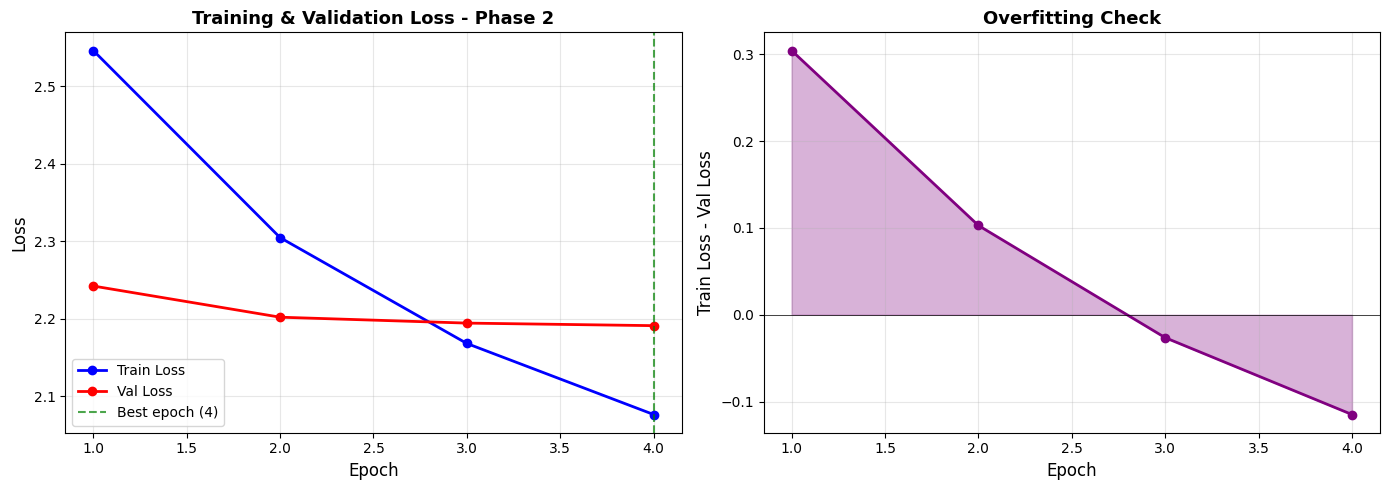


📊 DIAGNOSTIC D'ENTRAÎNEMENT
Meilleure val loss : 2.1909 (epoch 4)
Écart final        : -0.1148
✅ Val < Train → Modèle généralise bien

💾 SAUVEGARDE DU MODÈLE FINAL
✅ Modèle final sauvegardé : /content/drive/MyDrive/RCP217_Projet_Summarization/models/t5_small_phase2_final

📊 ÉVALUATION FINALE SUR TEST SET

Génération de 1500 résumés...


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:02<00:00, 524.57it/s]



📊 SCORES ROUGE MOYENS - T5 PHASE 2

ROUGE-1: F1=0.3489  P=0.3656  R=0.3452
ROUGE-2: F1=0.1368  P=0.1435  R=0.1353
ROUGE-L: F1=0.2425  P=0.2538  R=0.2402

💾 Sauvegarde des résultats...

🏆 COMPARAISON FINALE : EXTRACTIF vs ABSTRACTIF

| Métrique  | Extractif | T5 Phase 1 | T5 Phase 2 | Gain vs Extractif |
|-----------|-----------|------------|------------|-------------------|
| ROUGE1    | 0.2941    | 0.3519     | 0.3489     | +18.6%           |
| ROUGE2    | 0.0927    | 0.1443     | 0.1368     | +47.6%           |
| ROUGEL    | 0.1885    | 0.2483     | 0.2425     | +28.6%           |

✨ PHASE 2 TERMINÉE AVEC SUCCÈS !


In [ ]:
# ==========================================
# SCRIPT PRINCIPAL PHASE 2
# ==========================================

if __name__ == "__main__":

    print("="*60)
    print("🚀 PHASE 2 : ENTRAÎNEMENT COMPLET T5-SMALL")
    print("="*60)

    # Configuration
    config = ConfigPhase2()
    config.print_config()

    # Vérifier GPU
    if not torch.cuda.is_available():
        print("\n⚠️  ATTENTION : Pas de GPU détecté !")
        print("L'entraînement sur 10K exemples prendra plusieurs heures sur CPU.")
        response = input("Continuer quand même ? (y/n): ")
        if response.lower() != 'y':
            print("Arrêt du script. Activez GPU dans Runtime > Change runtime type")
            exit()

    # Charger données
    print("\n📂 CHARGEMENT DES DONNÉES")
    print("="*60)

    from google.colab import drive
    drive.mount('/content/drive')

    train_df = pd.read_pickle(f'{config.PROJECT_DIR}/train_data.pkl')
    val_df = pd.read_pickle(f'{config.PROJECT_DIR}/val_data.pkl')
    test_df = pd.read_pickle(f'{config.PROJECT_DIR}/test_data.pkl')

    # Échantillonnage
    train_sample = train_df.head(config.TRAIN_SIZE)
    val_sample = val_df.head(config.VAL_SIZE)
    test_sample = test_df.head(config.TEST_SIZE)

    print(f"✅ Train : {len(train_sample)} exemples")
    print(f"✅ Val   : {len(val_sample)} exemples")
    print(f"✅ Test  : {len(test_sample)} exemples")

    # Initialiser modèle
    print("\n🔧 INITIALISATION DU MODÈLE")
    print("="*60)

    tokenizer = T5Tokenizer.from_pretrained(config.MODEL_NAME)
    model = T5ForConditionalGeneration.from_pretrained(config.MODEL_NAME)
    model.to(config.DEVICE)

    print(f"✅ Modèle : {config.MODEL_NAME}")
    print(f"   Paramètres : {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

    # Préparer DataLoaders
    print("\n📦 PRÉPARATION DES DATALOADERS")
    print("="*60)

    train_dataset = CNNDailyMailDataset(train_sample, tokenizer,
                                        config.MAX_INPUT_LENGTH, config.MAX_TARGET_LENGTH)
    val_dataset = CNNDailyMailDataset(val_sample, tokenizer,
                                      config.MAX_INPUT_LENGTH, config.MAX_TARGET_LENGTH)

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE,
                             shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.EVAL_BATCH_SIZE,
                           shuffle=False, num_workers=2, pin_memory=True)

    print(f"✅ Train batches : {len(train_loader)}")
    print(f"✅ Val batches   : {len(val_loader)}")

    # Optimizer & Scheduler
    optimizer = AdamW(model.parameters(), lr=config.LEARNING_RATE)
    total_steps = len(train_loader) * config.NUM_EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=config.WARMUP_STEPS,
        num_training_steps=total_steps
    )

    # Entraîner
    print("\n" + "="*60)
    print("🏋️  DÉBUT DE L'ENTRAÎNEMENT")
    print("="*60)

    trainer = T5Trainer(model, tokenizer, config)

    for epoch in range(config.NUM_EPOCHS):
        print(f"\n{'='*60}")
        print(f"EPOCH {epoch+1}/{config.NUM_EPOCHS}")
        print(f"{'='*60}")

        train_loss = trainer.train_epoch(train_loader, optimizer, scheduler, epoch)
        val_loss = trainer.validate(val_loader)

        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"   Train Loss : {train_loss:.4f}")
        print(f"   Val Loss   : {val_loss:.4f}")
        print(f"   Gap        : {train_loss - val_loss:.4f}")

        # Sauvegarder meilleur modèle
        if val_loss == trainer.best_val_loss:
            print(f"   🌟 Nouveau meilleur modèle ! (val_loss={val_loss:.4f})")
            best_model_path = f'{config.PROJECT_DIR}/models/t5_small_phase2_best'
            os.makedirs(best_model_path, exist_ok=True)
            model.save_pretrained(best_model_path)
            tokenizer.save_pretrained(best_model_path)

    # Visualiser losses
    trainer.plot_losses(save_path='t5_phase2_training_curves.png')

    # Sauvegarder modèle final
    print("\n💾 SAUVEGARDE DU MODÈLE FINAL")
    final_model_path = f'{config.PROJECT_DIR}/models/t5_small_phase2_final'
    os.makedirs(final_model_path, exist_ok=True)
    model.save_pretrained(final_model_path)
    tokenizer.save_pretrained(final_model_path)
    print(f"✅ Modèle final sauvegardé : {final_model_path}")

    # ÉVALUATION FINALE
    print("\n" + "="*60)
    print("📊 ÉVALUATION FINALE SUR TEST SET")
    print("="*60)

    print(f"\nGénération de {len(test_sample)} résumés...")
    summaries_test = generate_summaries_batch(
        model, tokenizer, test_sample['article'].tolist(),
        config.DEVICE, config.MAX_INPUT_LENGTH, config.MAX_TARGET_LENGTH, config.NUM_BEAMS
    )

    # Évaluation ROUGE
    evaluator = ROUGEEvaluator()
    results_final, mean_final = evaluator.evaluate_dataset(
        summaries_test, test_sample['highlights'].tolist()
    )

    # Sauvegarder résultats
    print("\n💾 Sauvegarde des résultats...")
    results_dir = f'{config.PROJECT_DIR}/results'
    os.makedirs(results_dir, exist_ok=True)

    test_sample['generated_summary_t5'] = summaries_test
    test_sample.to_pickle(f'{results_dir}/t5_phase2_final_results.pkl')
    results_final.to_csv(f'{results_dir}/t5_phase2_rouge_scores.csv', index=False)
    mean_final.to_csv(f'{results_dir}/t5_phase2_mean_scores.csv', header=['score'])

    # Comparaison finale
    print("\n" + "="*60)
    print("🏆 COMPARAISON FINALE : EXTRACTIF vs ABSTRACTIF")
    print("="*60)

    extractive_scores = {'rouge1': 0.2941, 'rouge2': 0.0927, 'rougeL': 0.1885}
    phase1_scores = {'rouge1': 0.3519, 'rouge2': 0.1443, 'rougeL': 0.2483}

    print("\n| Métrique  | Extractif | T5 Phase 1 | T5 Phase 2 | Gain vs Extractif |")
    print("|-----------|-----------|------------|------------|-------------------|")

    for metric in ['rouge1', 'rouge2', 'rougeL']:
        ext = extractive_scores[metric]
        p1 = phase1_scores[metric]
        p2 = mean_final[f'{metric}_f']
        gain = ((p2 - ext) / ext) * 100

        print(f"| {metric.upper():<9} | {ext:.4f}    | {p1:.4f}     | {p2:.4f}     | {gain:+.1f}%           |")

    print("\n" + "="*60)
    print("✨ PHASE 2 TERMINÉE AVEC SUCCÈS !")
    print("="*60)

